# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

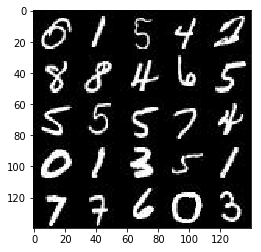

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

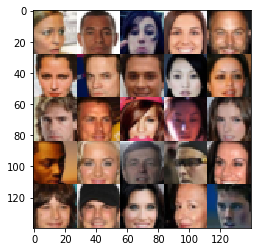

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [95]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [96]:
alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5

def leaky_relu(x, alpha):
    """
    A Leaky Rectified Linear Unit
    :param x: Input tensor
    :param alpha: Slope of the leaky output
    :return: Output tensor
    """
    return tf.maximum(alpha * x, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [99]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 0: 28x28x3 -> 14x14x64
        layer0 = tf.layers.conv2d(
            images, 64, 5, strides=2, padding='same', 
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer0 = leaky_relu(layer0, alpha)
        layer0 = tf.nn.dropout(layer0, d_dropout)
        
        # Layer 1: 14x14x64 -> 7x7x128
        layer1 = tf.layers.conv2d(
            layer0, 128, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)
        layer1 = tf.nn.dropout(layer1, d_dropout)
        
        # Layer 2: 4x4x256
        layer2 = tf.layers.conv2d(
            layer1, 256, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        layer2 = tf.nn.dropout(layer2, d_dropout)
        
        # Fully connected logits: 4x4x256 -> 4*4*256
        logits = tf.reshape(layer2, [-1, 4*4*256])
        logits = tf.layers.dense(logits, 1, activation=None)
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [100]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 0 (fully connected): z -> 4x4x512
        layer0 = tf.layers.dense(z, 4*4*512, activation=None)
        layer0 = tf.reshape(layer0, [-1, 4, 4, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)
        layer0 = tf.nn.dropout(layer0, g_dropout)
        
        # Layer 1: 4x4x512 -> 7x7x256
        layer1 = tf.layers.conv2d_transpose(
            layer0, 256, 4, strides=1, padding='valid',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        layer1 = tf.nn.dropout(layer1, g_dropout)
        
        # Layer 2: 7x7x256 -> 14x14x128
        layer2 = tf.layers.conv2d_transpose(
            layer1, 128, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        layer2 = tf.nn.dropout(layer2, g_dropout)
        
        # Layer 3: 14x14x128 -> 28x28x64
        layer3 = tf.layers.conv2d_transpose(
            layer2, 64, 5, strides=2, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3, alpha)
        layer3 = tf.nn.dropout(layer3, g_dropout)
        
        # Output image: 28x28x64 -> 28x28x3
        logits = tf.layers.conv2d_transpose(
            layer3, out_channel_dim, 5, strides=1, padding='same',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [101]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discriminators, one for real images, and one for fake (generated)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # For a real image, discriminator loss is deviation from an output of 1 (true)
    # Use label smoothing, see https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_output_real) * 0.9
    ))
    
    # For a fake image, discriminator loss is deviation from an output of 0 (false)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)
    ))
    
    # Total discriminator loss is the sum of the real and fake image losses
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss is the opposite of the discriminator loss for fake images
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_output_fake)
    ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [102]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get all variables
    t_vars = tf.trainable_variables()
    
    # Get weights and biases for the discriminator and generator
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [103]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [104]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale the domain from (-0.5, 0.5) to (-1, 1), since we are using tanh in that range
                batch_images = batch_images * 2
                
                # Noise (Z) input for the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimize weights and biases
                # Run g_opt twice, see https://github.com/carpedm20/DCGAN-tensorflow
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    g_train_loss = g_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.9739... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.4285
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 1.1870
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.4872... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.3399


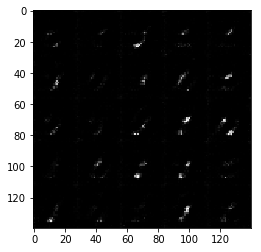

Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 1.6549... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 1.4891
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 1.1792
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.9593
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8523


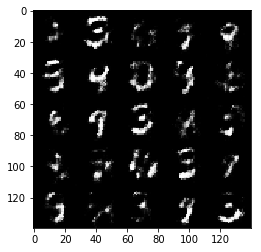

Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 1.3627
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.4013
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 1.2621
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 1.4643
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.8285


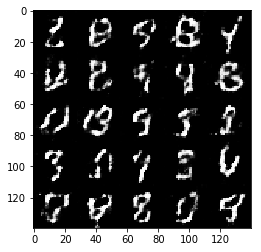

Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.9521
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 1.0591
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.2503
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 1.3711


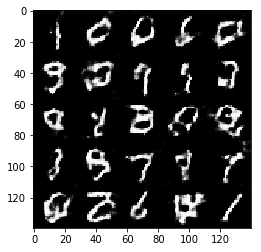

Epoch 1/2... Discriminator Loss: 1.2770... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 1.2202
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 1.5276
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.0118
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.9788
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 1.1827
Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 1.6469


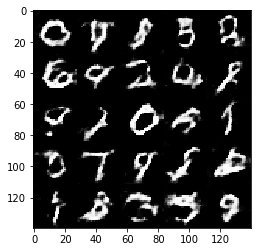

Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 0.9814
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.1626
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 1.1732


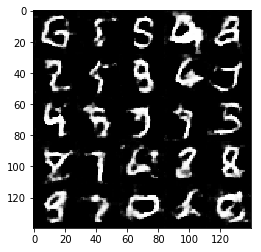

Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 1.4576
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.0609
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 1.0897
Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.8168


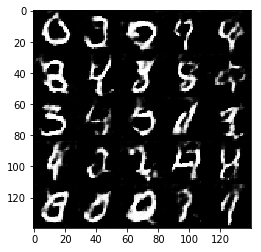

Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 0.9541
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.4554
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 1.4802


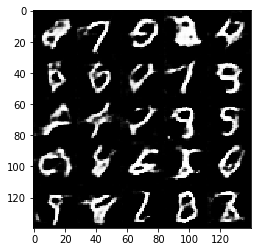

Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 1.0437
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.2394
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 1.0480


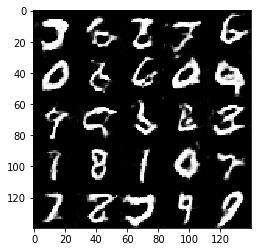

Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.3809
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 1.2490
Epoch 2/2... Discriminator Loss: 1.1916... Generator Loss: 1.7535
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.8315
Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.6994


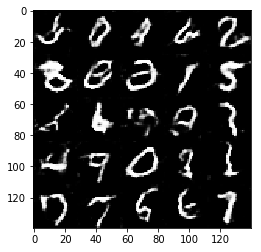

Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.0477
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 1.2484
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 1.3228
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 0.9706... Generator Loss: 1.1384
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 0.7648


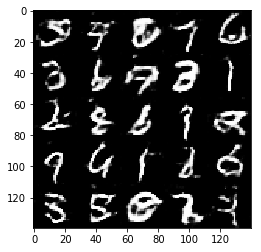

Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 0.9100... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.2159
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 1.8021
Epoch 2/2... Discriminator Loss: 1.0071... Generator Loss: 1.8227
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.6212
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.9292


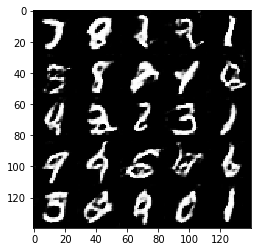

Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 1.7696
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.6451
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.3179
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.2964
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.4978


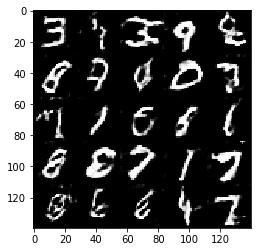

Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 1.0885... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 1.2768
Epoch 2/2... Discriminator Loss: 0.9485... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 1.3824
Epoch 2/2... Discriminator Loss: 0.9288... Generator Loss: 0.9222


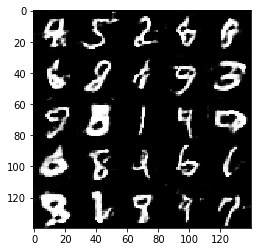

Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 0.9945
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.2826
Epoch 2/2... Discriminator Loss: 1.0963... Generator Loss: 1.9798
Epoch 2/2... Discriminator Loss: 1.0222... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.5573
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 1.7758
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.6540
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 1.7996


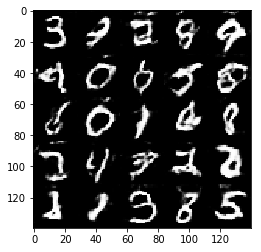

Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 2.1088
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.4790
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 2.2091
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 1.4477
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 2.0431
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 1.5617... Generator Loss: 2.3452
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.4557


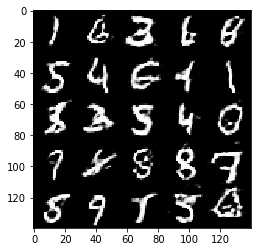

Epoch 2/2... Discriminator Loss: 0.9147... Generator Loss: 1.0577
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.6091
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 2.4206
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 1.5405


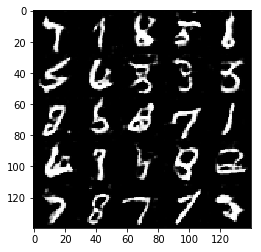

Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.6894
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 2.3231
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.7114
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.1702
Epoch 2/2... Discriminator Loss: 1.9395... Generator Loss: 2.7815
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 1.2191
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.6726


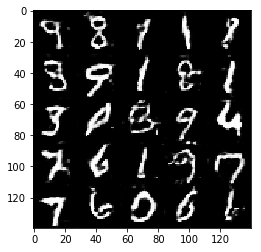

Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.3904
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.3449
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.4147
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.8607
Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.2834


In [92]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.3503
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.6572
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 2.3332... Generator Loss: 0.1819
Epoch 1/1... Discriminator Loss: 0.7693... Generator Loss: 6.3063
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 2.6123
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 3.8995
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 4.4466
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 4.0729
Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 4.8341


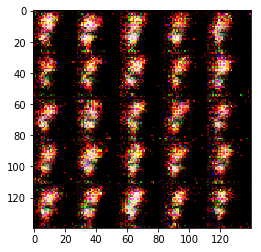

Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.8169
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 4.5340
Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 3.5566
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 4.2841
Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 4.5494
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 3.3815
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.7219
Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.6243
Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 3.9776
Epoch 1/1... Discriminator Loss: 0.4966... Generator Loss: 2.6796


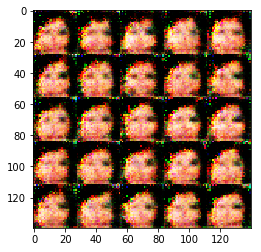

Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 4.4826
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 3.4904
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.8775
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 4.6972
Epoch 1/1... Discriminator Loss: 0.4357... Generator Loss: 3.1428
Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 4.6881
Epoch 1/1... Discriminator Loss: 0.3928... Generator Loss: 4.4511
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 4.4343
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4534


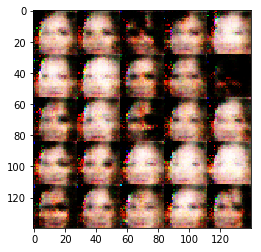

Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 3.6218
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 2.0572
Epoch 1/1... Discriminator Loss: 3.0869... Generator Loss: 7.8397
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 3.5811


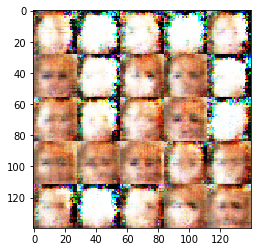

Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.8227
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.5389
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.9851
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.4129
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.5870


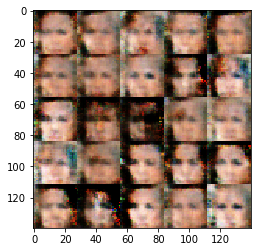

Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.4742
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.6413
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 1.0605


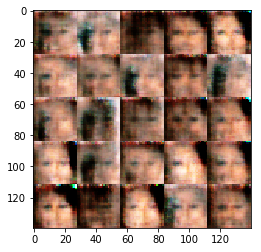

Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.4637


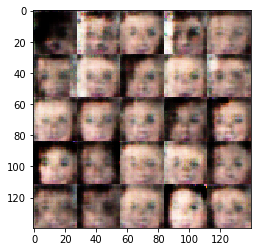

Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.0617


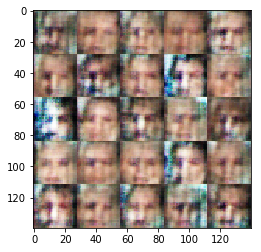

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.3803


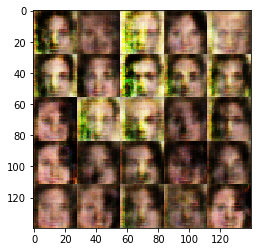

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.2357
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.6085
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9933


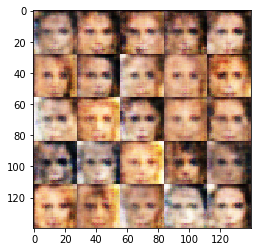

Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.4000
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.3050


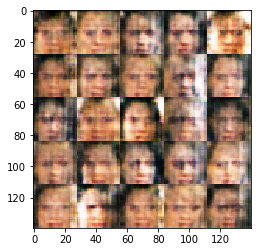

Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.4036


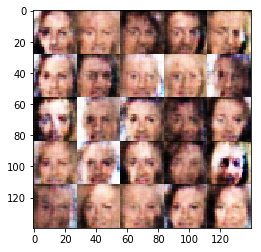

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.7362
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.9384
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0865
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9750


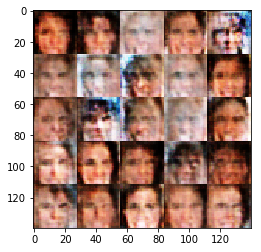

Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.3160
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 1.5604
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.1884


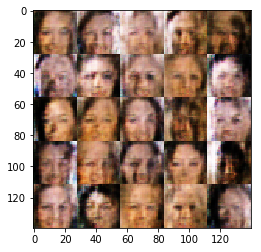

Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.6582
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6505


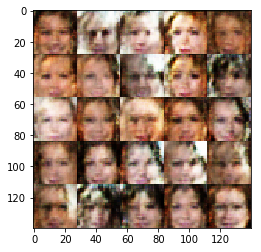

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.3792
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.9742


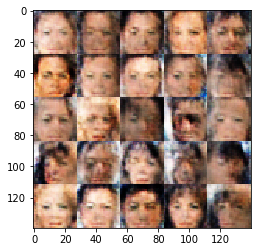

Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.2290


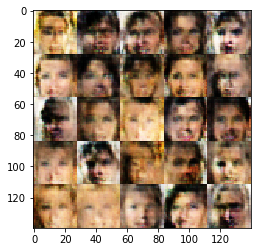

Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.1915


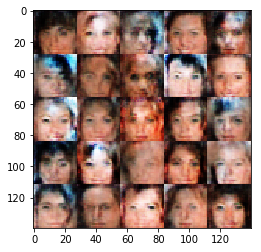

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.3145


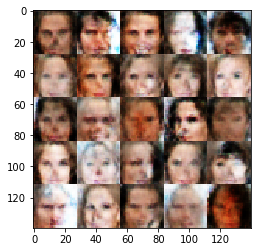

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.3112
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.3169
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.1373


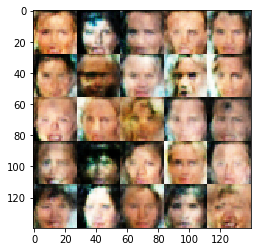

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.4428
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.1111


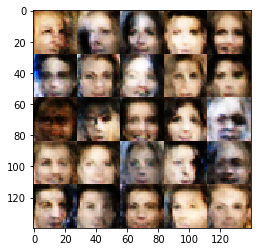

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.1325


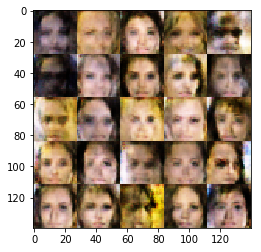

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.0186


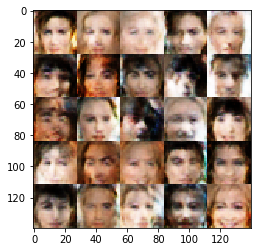

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 1.0196
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.2175
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.0467


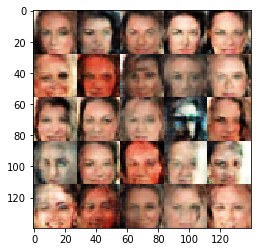

Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.3921
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.1873


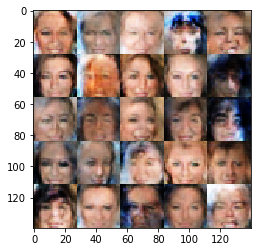

Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.1805
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9947


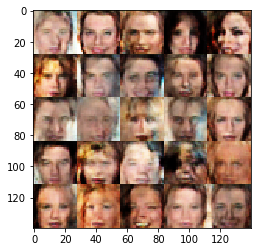

Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.2441


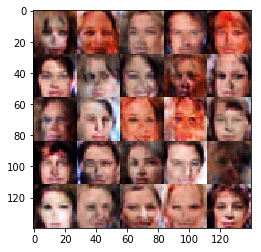

Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9769


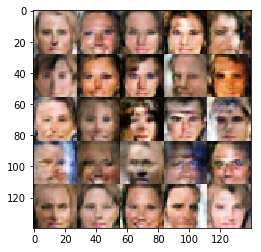

Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.1630


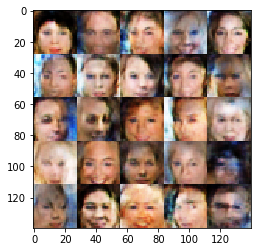

Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.1932


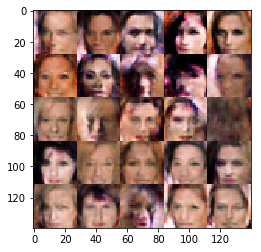

Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.4724
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.7338


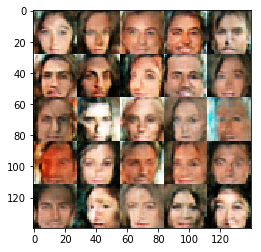

Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.0920
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0084


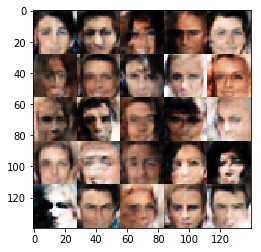

Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.3452


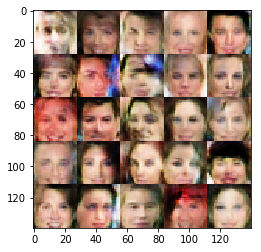

Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8100


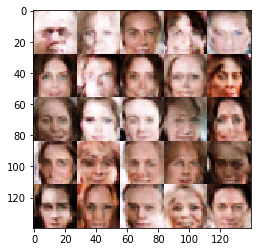

Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.8998


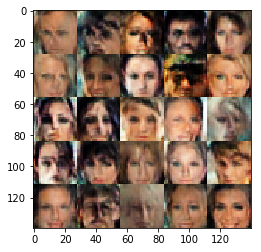

Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9888
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.3535
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.2215


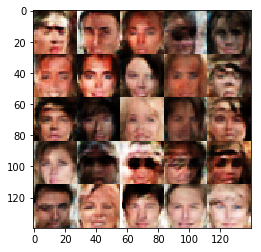

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.8578


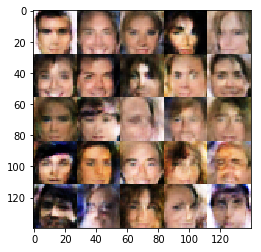

Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.3207
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.2614


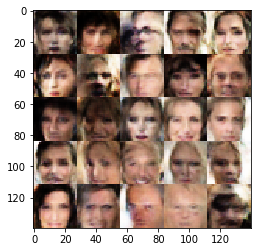

Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.7588


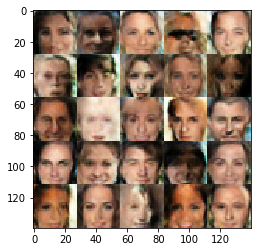

Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7599


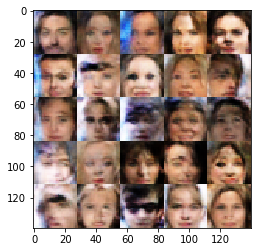

Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.3718
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.1972
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 1.2941


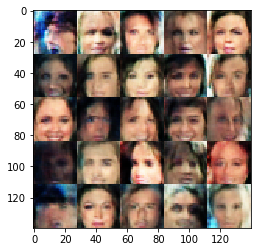

Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.3684
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.4857


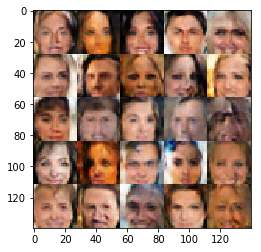

Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.8560


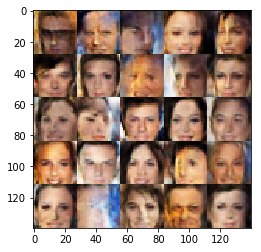

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.1335
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.3493


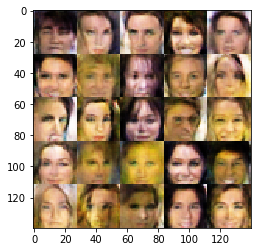

Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.2307


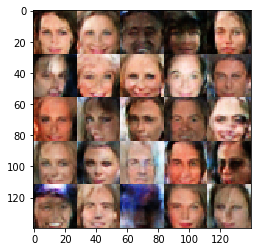

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.5598
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.7555


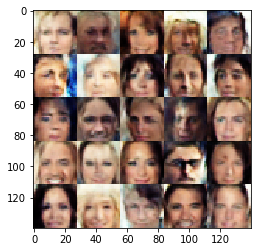

Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.0469


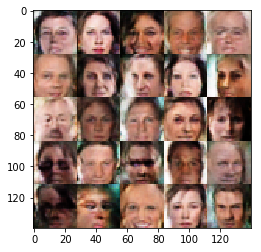

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.6098
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.3291


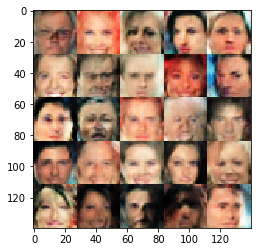

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.5062
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.9904


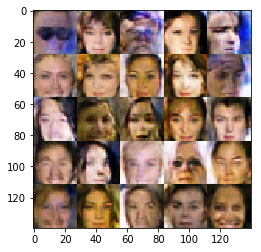

Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.4141


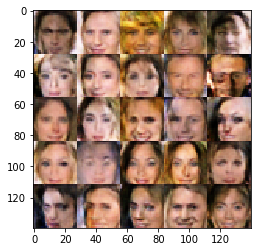

Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.4908


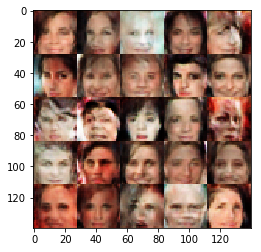

Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.3798


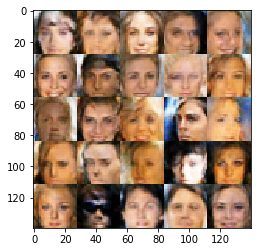

Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.1105


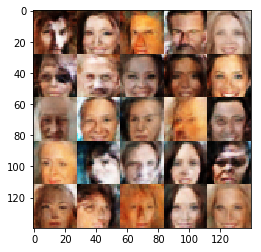

Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.6472
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.4218


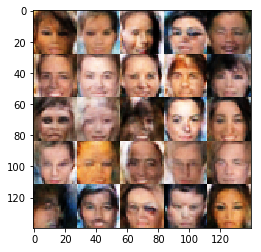

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.4740
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.5461
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.7666
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 2.0846


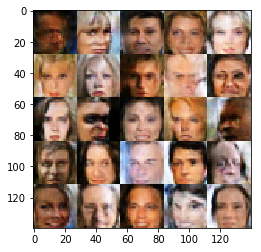

Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.1385
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.5078


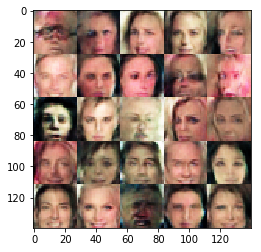

Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.6410


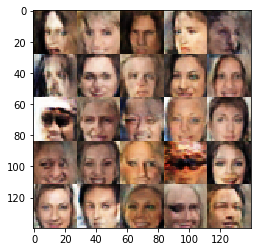

Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.7032
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.3965


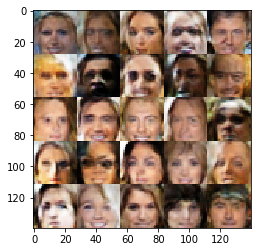

Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.0797


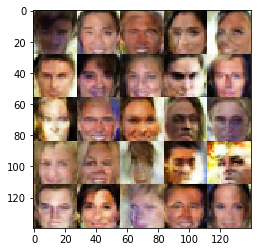

Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.6335
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.3011


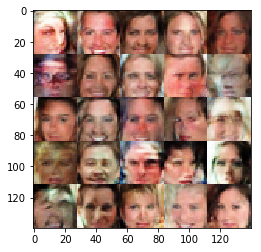

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.3846
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0802


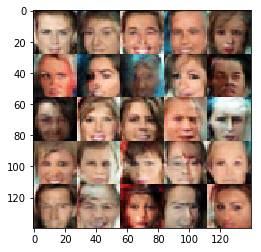

Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.4510
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.3768
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.5256
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.6627


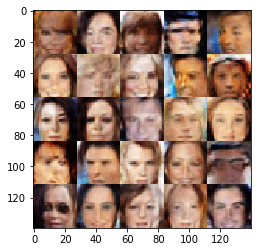

Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.6235
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.0768


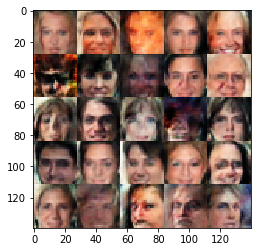

Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.2464


In [105]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

alpha = 0.2
d_dropout = 0.9
g_dropout = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.